In [ ]:

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import torch.nn.functional as nn
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
from tensorflow.examples.tutorials.mnist import input_data



In this notebook, I'll be describing the way [Info_GANs](https://arxiv.org/pdf/1606.03657) work.

For a better understanding of InfoGANs, it's better to have grip on GANs, CGANs (Conditional GANs).

GAN = Generative Adversarial Network , has two neural networks , one called as generator and other is a discriminator. The 
task of generator is to mimic the probability distribution of given dataset. At a high level, a generative model means you have mapped the probability distribution of the data itself. In the case of images, that means you have a probability for every possible combination of pixel values. This also means you can generate new data points by sampling from this distribution ( by choosing combinations with large probability). In Computer vision, this means that we can generate new images entirely from no prior data.

The way it works is similar to a thief and police story. Imagine that a thief always wants to generate fake notes (mimic actual images distribution / mimic actual images (pixel combinations) ) and fool the police to get away with it. Police, on the other hand, wants to determine ways to detect fake notes (To detect a sample that comes from generated probability distribution). It is like a constant mutual development process.

Our stable state is having an equally trained Discriminator (Police to catch fake notes) and Generator (Skilled criminal to mimic currency).

How do we do that ?

In every iteration, 

1. Generator takes a random noise data (vector) and outputs an image (which intially looks like noise). Now you have a bunch of noisy images and true images. You pass this bunch of Noisy images (Label False) and True images (Labelled True) through Discriminator (a neural network). You could see that this turned out to be a simple supervised task of classification. So we train our Discriminator keeping generator untrained.

2. We pass random noise again through Generator to generate fake images. We pass this fake images labelled as True ,(To fool the discriminator) through the discriminator. When passed through Discriminator (Police), we will know the places where we fail to fool the police. Notice the differences and we(Criminal/Generator) work on them. Note that we work on Police's current state of mind, which  means we keep discriminator untrianed during this process.

know the places where we fail to fool the police == Compute loss

Notice the differences and work on them  == Compute gradients and update weights of generator


Conditional GANs = If you've gone through the above description of GANs, you might have understood that generator generates samples from random noise(Entangled Representation). Wouldn't it be nice if we input a known vector (Disentangled representation) instead of random noise ? Let's say I want to generate handwritten images of a given number. This (Label ===> model ==> image) is the reverse of image classification (image ===> model ==> Label). We are passing in conditional information to the generator for producing images. On the other hand, instead of making the discriminator just classify the images real/fake we pass the label along with the image. Now discriminating, it is classifying whether the label given to the input image is true/not.


InfoGAN = This is similar to Conditional GANs, but we don't want to specify the information. Let's make neural networks do that for us ? But WHY ?

Because when passing real world data like faces,images of buildings, there are a lot of hidden concepts a.k.a Latent concepts. Neural Networks are capable of capturing this latent concepts well because of their non-linear activation functions.

Sounds good. How do we do that ?

For the generator we pass in Z (Random Noise) along with C (categorical distribution). Note that C's distribution may vary with the application to Gaussian / whatever. If it is a categorical distribution, you expect C to be one-hot encoded vector.
Like [0 0 0 1] for representing a concept. We start with a uniformly distributed C [0.2 0.2 0.2 0.2 0.2].


And with the training process, we expect neural network architecture to update C.

There's only one change compared to GANs & CGANs i.e an additional neural network Q_C to monitor C.

Process is similar,
1.Train discriminator (As usual)
2.Train Generator (As usual)
3.Generate samples from given random noise and initial C. These generated samples are given to Q_C, which in turn learns latent concepts from C.

#### Download mnist dataset


In [4]:
mnist = input_data.read_data_sets('../../MNIST_data', one_hot=True)
mb_size = 32  # batch_size
Z_dim = 16  # Random noise input for generator
X_dim = mnist.train.images.shape[1]
y_dim = mnist.train.labels.shape[1]
h_dim = 128   # Hidden layer dimension
cnt = 0
lr = 1e-3


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../../MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../../MNIST_data\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ../../MNIST_data\t10k-images-idx3-ubyte.gz
Extracting ../../MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.



Articles related to Xavier initialization explaining how it deals with the saturation of inputs in activation functions.

[1.Shi Yan, Medium](https://medium.com/@shiyan/xavier-initialization-and-batch-normalization-my-understanding-b5b91268c25c)

[2.Andy Jones, Tumblr](http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization)

The idea is randomizing the initial weights, so that the inputs of each activation function fall within the sweet range of the activation function. Ideally, none of the neurons should start with a trapped situation.

This post is a great material on Xavier initialization. Basically it tries to make sure the distribution of the inputs to each activation function is zero mean and unit variance. To do this, it assumes that the input data has been normalized to the same distribution. The more number of inputs a neuron has, the smaller the initial weights should be, in order to compensate the number of inputs. In a word, the Xavier initialization method tries to initialize weights with a smarter value, such that neurons won’t start training in saturation.

In [5]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / np.sqrt(in_dim / 2.)
    return Variable(torch.randn(*size) * xavier_stddev, requires_grad=True)


 # ##  ==================== GENERATOR ========================

Input is Z (Random Noise), C (categorical distribution for 10 digits)

Output is image

In [6]:
""" ==================== GENERATOR ======================== """

Wzh = xavier_init(size=[Z_dim + 10, h_dim])
bzh = Variable(torch.zeros(h_dim), requires_grad=True)

Whx = xavier_init(size=[h_dim, X_dim])
bhx = Variable(torch.zeros(X_dim), requires_grad=True)

#Initialising weights and biases for generator neural network

#  (Input, Output)
 
#  Layer 1                Layer 2     
#  (16+10, h_dim)   ==> (h_dim, X_dim)

def G(z, c):
    inputs = torch.cat([z, c], 1)
    h = nn.relu(inputs @ Wzh + bzh.repeat(inputs.size(0), 1))
    X = nn.sigmoid(h @ Whx + bhx.repeat(h.size(0), 1))
    return X


#  ==================== DISCRIMINATOR ========================

Input is the image 

Output is the prediction of real/fake

In [7]:

Wxh = xavier_init(size=[X_dim, h_dim])
bxh = Variable(torch.zeros(h_dim), requires_grad=True)

Why = xavier_init(size=[h_dim, 1])
bhy = Variable(torch.zeros(1), requires_grad=True)


def D(X):
    h = nn.relu(X @ Wxh + bxh.repeat(X.size(0), 1))
    y = nn.sigmoid(h @ Why + bhy.repeat(h.size(0), 1))
    return y


### ====================== Q(c|X) ========================== 

Q (Neural Network that learns C distribution) learns from the learnt Generator from discriminator in every iteration.

Input is the generated image and output is updated C, based on the generated image

In [8]:

Wqxh = xavier_init(size=[X_dim, h_dim])
bqxh = Variable(torch.zeros(h_dim), requires_grad=True)

Whc = xavier_init(size=[h_dim, 10])
bhc = Variable(torch.zeros(10), requires_grad=True)


def Q(X):
    h = nn.relu(X @ Wqxh + bqxh.repeat(X.size(0), 1))
    c = nn.softmax(h @ Whc + bhc.repeat(h.size(0), 1))
    return c


G_params = [Wzh, bzh, Whx, bhx]
D_params = [Wxh, bxh, Why, bhy]
Q_params = [Wqxh, bqxh, Whc, bhc]
params = G_params + D_params + Q_params


Iter-0; D_loss: 0.2906971871852875; G_loss: 2.9981160163879395; Idx: 6


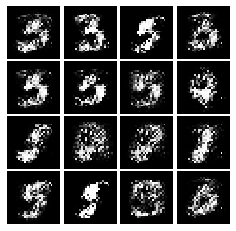

Iter-1000; D_loss: 0.3376256227493286; G_loss: 3.2561426162719727; Idx: 5


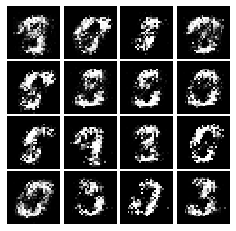

Iter-2000; D_loss: 0.5290055274963379; G_loss: 2.6927003860473633; Idx: 4


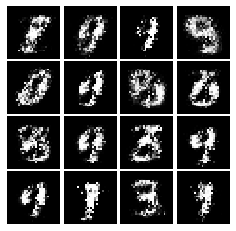

Iter-3000; D_loss: 0.38271602988243103; G_loss: 2.7206637859344482; Idx: 6


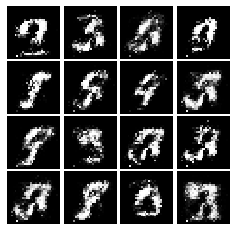

Iter-4000; D_loss: 0.4713249206542969; G_loss: 2.9295167922973633; Idx: 2


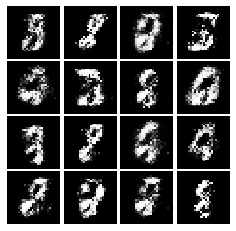

Iter-5000; D_loss: 0.6832974553108215; G_loss: 2.9968669414520264; Idx: 1


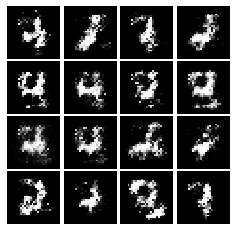

Iter-6000; D_loss: 0.8471986651420593; G_loss: 2.932690382003784; Idx: 4


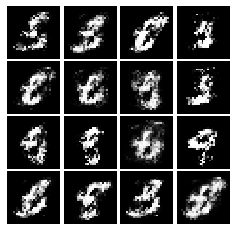

Iter-7000; D_loss: 0.7906712889671326; G_loss: 2.6806297302246094; Idx: 4


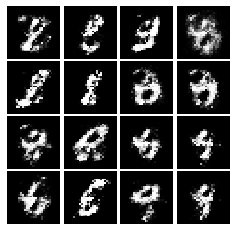

Iter-8000; D_loss: 0.7548340559005737; G_loss: 2.128370523452759; Idx: 1


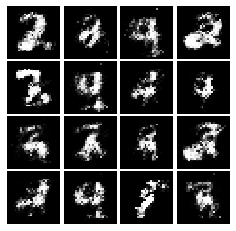

KeyboardInterrupt: 

In [10]:
""" ===================== TRAINING ======================== """


def reset_grad():
    for p in params:
        if p.grad is not None:
            data = p.grad.data
            p.grad = Variable(data.new().resize_as_(data).zero_())


G_solver = optim.Adam(G_params, lr=1e-3)
D_solver = optim.Adam(D_params, lr=1e-3)
Q_solver = optim.Adam(G_params + Q_params, lr=1e-3)


### Generate a categorical distribution, with equal probability for each of the ten elements.

# Remember that we start with a random categorical distribution [0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 ]

# At the end, we expect InfoGAN to embed latent contents into categorical distribution that is , categorical representation

# for each digit (Like one-hot encoding)

def sample_c(size):
    c = np.random.multinomial(1, 10*[0.1], size=size)
    c = Variable(torch.from_numpy(c.astype('float32')))
    return c
### We start with sample_c



## 100000

for it in range(100000):
    
    
    # Sample data
    
    X, _ = mnist.train.next_batch(mb_size)   ## Get a batch of size 32
    X = Variable(torch.from_numpy(X))        ## Convert to torch variable for updating it.    

    z = Variable(torch.randn(mb_size, Z_dim)) ## z (32,16) ==> 16-size random vector for each example
    c = sample_c(mb_size)                     ## Create uniform categorical distribution for the batch. (32,10) [[0.2,..0.2],[0.2,..,0.2]]  

    

    # Dicriminator forward-loss-backward-update (Only Train Disc but not generator and Q_c)

# ================================== START ==========================================

    G_sample = G(z, c)                       ## Generate images given random noise z and prior c.
    D_real = D(X)                            ## Make predictions on the actual images.Ideally D_real shud classify it as real.
    D_fake = D(G_sample)                     ## Make predictions on the fake (generated) images.

    D_loss = -torch.mean(torch.log(D_real + 1e-8) + torch.log(1 - D_fake + 1e-8))
    
    ## Classify real images as True (1) and fake images as False (0)

    D_loss.backward()   ## Backpropagate (Calculate gradients)
    D_solver.step()     ## Update weights

    # Housekeeping - reset gradient
    reset_grad()
# ================================= STOP =============================================



    # Generator forward-loss-backward-update

# ================================== START ==========================================


    G_sample = G(z, c)                    ## Generate images given random noise z and prior c.
    D_fake = D(G_sample)                  ## Make predictions on the fake (generated) images.

    G_loss = -torch.mean(torch.log(D_fake + 1e-8))
    
    ## Classify fake images as True (1)

    G_loss.backward()
    G_solver.step()

    # Housekeeping - reset gradient
    reset_grad()

    
# ================================== STOP ==========================================


    # Q forward-loss-backward-update
    
# ================================== START ==========================================

    G_sample = G(z, c)                    ## Generate images given random noise z and prior c.
    Q_c_given_x = Q(G_sample)             ## Generate Q_C (New C)

    crossent_loss = torch.mean(-torch.sum(c * torch.log(Q_c_given_x + 1e-8), dim=1))
    mi_loss = crossent_loss

    mi_loss.backward()
    Q_solver.step()

    # Housekeeping - reset gradient
    reset_grad()

# ================================== STOP ==========================================


    # Print and plot every now and then
    if it % 1000 == 0:
        idx = np.random.randint(0, 10)
        c = np.zeros([mb_size, 10])
        c[range(mb_size), idx] = 1
        c = Variable(torch.from_numpy(c.astype('float32')))
        samples = G(z, c).data.numpy()[:16]

        print('Iter-{}; D_loss: {}; G_loss: {}; Idx: {}'
              .format(it, D_loss.data.numpy(), G_loss.data.numpy(), idx))

        fig = plt.figure(figsize=(4, 4))
        gs = gridspec.GridSpec(4, 4)
        gs.update(wspace=0.05, hspace=0.05)

        for i, sample in enumerate(samples):
            ax = plt.subplot(gs[i])
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            plt.imshow(sample.reshape(28, 28), cmap='Greys_r')
            
        if not os.path.exists('out/'):
            os.makedirs('out/')

        plt.savefig('out/{}.png'
                    .format(str(cnt).zfill(3)+"label_"+str(idx)), bbox_inches='tight')
        cnt += 1
        plt.show()
        plt.close(fig)